In [14]:
import pandas as pd
from utils import *
import numpy as np
import folium
from IPython.display import display
import matplotlib.pyplot as plt
import folium

## Data preprocessing

### Reading the Airport codes data

In [4]:
airport_codes = pd.read_csv('Airport_Codes.csv')
airport_codes = split_df_columns(airport_codes, 'COORDINATES', ['LONGITUDE','LATITUDE'])
airport_codes.head()

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,LONGITUDE,LATITUDE
0,heliport,Total Rf Heliport,11.0,NaN,US,Bensalem,NaN,-74.93360137939453,40.07080078125
1,small_airport,Aero B Ranch Airport,3435.0,NaN,US,Leoti,NaN,-101.473911,38.704022
2,small_airport,Lowell Field,450.0,NaN,US,Anchor Point,NaN,-151.695999146,59.94919968
3,small_airport,Epps Airpark,820.0,NaN,US,Harvest,NaN,-86.77030181884766,34.86479949951172
4,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,Newport,NaN,-91.254898,35.6087


I splitted the coordinates column into Longitude and coordinates

### Reading the Metadata data

In [5]:
metadata = read_excel_tabs('Airline_Challenge_Metadata.xlsx')
dataset_meta, airport_codes_meta, flights_meta, tickets_meta = metadata
dataset_meta.head()

,Dataset Name,Description
0,Airport_Codes,Information on airports and includes airport c...
1,Flights,"Flights data for Q1 2019 and includes date, or..."
2,Tickets,Sample tickets data for Q1 2019 and includes i...


###  Reading the Flights data

In [6]:
flights = pd.read_csv('Flights.csv', parse_dates=['FL_DATE'])

C:\Users\Ali Kone\AppData\Local\Temp\ipykernel_24100\3761071849.py:1: DtypeWarning: Columns (3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('Flights.csv', parse_dates=['FL_DATE'])


In [7]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915886 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   TAIL_NUM           object 
 3   OP_CARRIER_FL_NUM  object 
 4   ORIGIN_AIRPORT_ID  int64  
 5   ORIGIN             object 
 6   ORIGIN_CITY_NAME   object 
 7   DEST_AIRPORT_ID    int64  
 8   DESTINATION        object 
 9   DEST_CITY_NAME     object 
 10  DEP_DELAY          float64
 11  ARR_DELAY          float64
 12  CANCELLED          float64
 13  AIR_TIME           object 
 14  DISTANCE           object 
 15  OCCUPANCY_RATE     float64
dtypes: float64(4), int64(2), object(10)
memory usage: 233.9+ MB


The flights dataset contains 1915886 rows and 16 columns. Most of the columns have the wrong data type (`object`) as shown above. Some of the columns such as columns 3, 13 and 14 have a mixed type as indicated by the warning when loading the CSV into a dataframe. We are going to use the `sanitize_df_columns` function from the `utils` module to clean these columns.


In [8]:
# Sanitizing the flights dataset
columns_to_sanitize = ["OP_CARRIER_FL_NUM","AIR_TIME","DISTANCE"]
for col in columns_to_sanitize:
    sanitize_df_columns(flights, col)

flights.info()

Sanitizing OP_CARRIER_FL_NUM...
Sanitizing OP_CARRIER_FL_NUM done.
Sanitizing AIR_TIME...
Sanitizing AIR_TIME done.
Sanitizing DISTANCE...
Sanitizing DISTANCE done.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915886 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   FL_DATE            datetime64[ns]
 1   OP_CARRIER         object        
 2   TAIL_NUM           object        
 3   OP_CARRIER_FL_NUM  float64       
 4   ORIGIN_AIRPORT_ID  int64         
 5   ORIGIN             object        
 6   ORIGIN_CITY_NAME   object        
 7   DEST_AIRPORT_ID    int64         
 8   DESTINATION        object        
 9   DEST_CITY_NAME     object        
 10  DEP_DELAY          float64       
 11  ARR_DELAY          float64       
 12  CANCELLED          float64       
 13  AIR_TIME           float64       
 14  DISTANCE           float64       
 15  OCCUPANCY_RATE     float64       
dtypes: datetime64[n

We observe that there are missing  values in some column of the flights dataset. Let get a look at the missing values and deal with them.

In [9]:
flights.isnull().sum()

FL_DATE                    0
OP_CARRIER                 0
TAIL_NUM                   0
OP_CARRIER_FL_NUM         40
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
ORIGIN_CITY_NAME           0
DEST_AIRPORT_ID            0
DESTINATION                0
DEST_CITY_NAME             0
DEP_DELAY              50351
ARR_DELAY              55991
CANCELLED                  0
AIR_TIME             1913576
DISTANCE             1913806
OCCUPANCY_RATE           310
dtype: int64

This dataset  has a lot of missing values. The most important columns are `OP_CARRIER_FL_NUM` which have 40 missing values, `DEP_DELAY` which have 50351 missing values, `ARR_DELAY` which have 55991 missing values and `OCCUPANCY_RATE` which have 310 missing values and `DISTANCE` which have 1,913,806 missing values. These are the most important columns because they are used in the calculation of business metrics( busiest routes, most profitable routes, most popular routes, etc.).

There are 2 options when dealing with these missing values, we either drop the missing values or replace them with an inputed value which could be the mean, median, mode of the other values or even with zero.
- The `OP_CARRIER_FL_NUM` column has 40 missing values and this column does not have any specific meaning. We will drop these values.
- For the `ARR_DELAY` column and `DEP_DELAY` column, we can safely assume that the missing values are zero. because these values represent (`55,991/1,915,886 = 2.93% `) and (`50,351/1,915,886 = 2.63% `) 
of the total dataset, so the absence must mean that there was no delay.
- For the `DISTANCE` and `OCCUPANCY_RATE` columns, we will inpute the missing values with the median of the other values because any completed flights will have some distance between the origin and the destination and a non-zero occupancy rate. The median was chosen instead of the mean because the median is more robust to outliers.

In [10]:
flights.dtypes

FL_DATE              datetime64[ns]
OP_CARRIER                   object
TAIL_NUM                     object
OP_CARRIER_FL_NUM           float64
ORIGIN_AIRPORT_ID             int64
ORIGIN                       object
ORIGIN_CITY_NAME             object
DEST_AIRPORT_ID               int64
DESTINATION                  object
DEST_CITY_NAME               object
DEP_DELAY                   float64
ARR_DELAY                   float64
CANCELLED                   float64
AIR_TIME                    float64
DISTANCE                    float64
OCCUPANCY_RATE              float64
dtype: object

In [11]:
# Drop the missing values
flights = flights.dropna(subset=['OP_CARRIER_FL_NUM'])

#Filling in the missing values with zero
flights[["ARR_DELAY","DEP_DELAY"]] = flights[["ARR_DELAY","DEP_DELAY"]].fillna(0)

# Fill missing values in 'DISTANCE' and 'OCCUPANCY_RATE' with median
median_distance = flights['DISTANCE'].median()
median_occupancy_rate = flights['OCCUPANCY_RATE'].median()


flights['DISTANCE'] = flights['DISTANCE'].fillna(median_distance)
flights['OCCUPANCY_RATE'] = flights['OCCUPANCY_RATE'].fillna(median_occupancy_rate)

In [12]:
flights.isnull().sum()

FL_DATE                    0
OP_CARRIER                 0
TAIL_NUM                   0
OP_CARRIER_FL_NUM          0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
ORIGIN_CITY_NAME           0
DEST_AIRPORT_ID            0
DESTINATION                0
DEST_CITY_NAME             0
DEP_DELAY                  0
ARR_DELAY                  0
CANCELLED                  0
AIR_TIME             1913576
DISTANCE                   0
OCCUPANCY_RATE             0
dtype: int64

The flights dataset does not have any missing values now except for `AIR_TIME` which is not relevant for the purpose of our analysis. We can move on with loading and cleaning other datasets

### Reading the tickets data

In [13]:
tickets = pd.read_csv('Tickets.csv')

In [14]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167285 entries, 0 to 1167284
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ITIN_ID            1167285 non-null  int64  
 1   YEAR               1167285 non-null  int64  
 2   QUARTER            1167285 non-null  int64  
 3   ORIGIN             1167285 non-null  object 
 4   ORIGIN_COUNTRY     1167285 non-null  object 
 5   ORIGIN_STATE_ABR   1167285 non-null  object 
 6   ORIGIN_STATE_NM    1167285 non-null  object 
 7   ROUNDTRIP          1167285 non-null  float64
 8   REPORTING_CARRIER  1167285 non-null  object 
 9   PASSENGERS         1165308 non-null  float64
 10  ITIN_FARE          1166325 non-null  object 
 11  DESTINATION        1167285 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 106.9+ MB


The `INTIN_FARE` column has the wrong data type (`Object`) because the column includes some characters that are not numbers. We are going to use the `sanitize_df_columns` function from the `utils` module to clean this `tickets` data as well.

In [15]:
sanitize_df_columns(tickets, 'ITIN_FARE', parse_dates=False)

Sanitizing ITIN_FARE...
Sanitizing ITIN_FARE done.


,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,201912723049,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,NaN,DAB
1,201912723085,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,NaN,COS
2,201912723491,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,NaN,MCO
3,201912723428,2019,1,ABI,US,TX,Texas,1.0,MQ,1.0,NaN,LGA
4,201912723509,2019,1,ABI,US,TX,Texas,0.0,MQ,1.0,NaN,MGM
...,...,...,...,...,...,...,...,...,...,...,...,...
1167280,201911284909,2019,1,YAK,US,AK,Alaska,0.0,AS,1.0,NaN,ANC
1167281,201911284959,2019,1,YAK,US,AK,Alaska,1.0,AS,1.0,NaN,JNU
1167282,201911284940,2019,1,YAK,US,AK,Alaska,0.0,AS,1.0,NaN,JNU
1167283,201911284914,2019,1,YAK,US,AK,Alaska,0.0,AS,1.0,NaN,ANC


After the clean up all columns have the relevant data types.

# Data Analysis

In [17]:
print(airport_codes.shape)
print(flights.shape)
print(tickets.shape)

(55369, 9)
(1915846, 16)
(1167285, 12)


### Identifying all flights completed in Q1 2019

In [18]:
flights.FL_DATE.describe()

count                          1915846
mean     2019-02-15 10:15:47.447341568
min                2019-01-01 00:00:00
25%                2019-01-24 00:00:00
50%                2019-02-16 00:00:00
75%                2019-03-10 00:00:00
max                2019-03-31 00:00:00
Name: FL_DATE, dtype: object

All flights were completed in Q1 2019. So there is no filter for flights that were not completed in Q1 2019.

In [19]:
# Convert columns to strings for merge  
flights['ORIGIN_AIRPORT_ID'] = flights['ORIGIN_AIRPORT_ID'].astype(str)
flights['DEST_AIRPORT_ID'] = flights['DEST_AIRPORT_ID'].astype(str)

# Join tickets info
flights = flights.merge(tickets, how='left', left_on=['ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID'], right_on=['ORIGIN','DESTINATION'])

# Join the airport codes info
flights = flights.merge(airport_codes, left_on='ORIGIN_x', right_on='IATA_CODE')

# Filter the merged dataset to medium and large hubs only
flights = flights[flights['TYPE'].isin(['medium_airport','large_airport'])]

# Identifying non-cancelled flights in Q1 2019
flights = flights[flights['CANCELLED'] == 0] 

# Create a dictionary to map airport IDs to IATA codes
airport_iata_map = flights.set_index('ORIGIN_AIRPORT_ID')['IATA_CODE'].to_dict()

# Map IATA codes to ORIGIN_AIRPORT_ID
flights['ORIGIN_IATA_CODE'] = flights['ORIGIN_AIRPORT_ID'].map(airport_iata_map)

# Map IATA codes to DEST_AIRPORT_ID
flights['DEST_IATA_CODE'] = flights['DEST_AIRPORT_ID'].map(airport_iata_map)

### Indentifying 10 busiest routes in Q1 2019

In [46]:
top_ten_flights = flights_stats(flights)

format_numeric_columns(top_ten_flights)

,ORIGIN_IATA_CODE,DEST_IATA_CODE,number_of_flights
2935,LAX,SFO,"8,340"
3038,LGA,ORD,"7,156"
2795,LAS,LAX,"6,511"
2670,JFK,LAX,"6,320"
2934,LAX,SEA,"4,999"
580,BOS,LGA,"4,820"
2214,HNL,OGG,"4,794"
4168,PDX,SEA,"4,774"
201,ATL,MCO,"4,707"
197,ATL,LGA,"4,594"


### Identifying 10 most profitable routes

#### Revenue calculation

In [25]:
flights['Revenue'] = 200 * flights['OCCUPANCY_RATE'] * 400 # $400 average ticket price 
flights['Baggage'] = 200 *  flights['OCCUPANCY_RATE'] * 70 * 0.5 # $70 avg baggage revenue per RT flight
flights['TotalRevenue'] = flights['Revenue'] + flights['Baggage']

#### Cost Calculation

In [26]:
flights['AirportFees'] = np.where(flights['TYPE'] == 'medium_airport', 5_000, 10_000)



In [27]:
flights['Cost'] = flights['DISTANCE'] * 9.18 + flights['AirportFees'] # $9.18 cost per mile
flights['DelayCost'] = ((flights['DEP_DELAY'] + flights['ARR_DELAY'] - 30) * 75).clip(lower=0) # Delay cost
flights['TotalCost'] = flights['Cost'] + flights['DelayCost'] 

#### Profit Calculation

In [45]:
flights['Profit'] = flights['TotalRevenue'] - flights['TotalCost']
top_ten_profits = flights_stats(flights, group_keys=['ORIGIN_IATA_CODE', 'DEST_IATA_CODE'], aggregate_cols=['TotalRevenue','TotalCost','Profit'], new_aggreg_name="Profit", count=False, top_n=10)
format_numeric_columns(top_ten_profits)

,ORIGIN_IATA_CODE,DEST_IATA_CODE,Profit
2935,LAX,SFO,"316,104,510"
3038,LGA,ORD,"268,381,208"
2795,LAS,LAX,"255,189,743"
2670,JFK,LAX,"248,817,625"
2214,HNL,OGG,"204,707,852"
2934,LAX,SEA,"199,042,682"
4168,PDX,SEA,"188,683,157"
201,ATL,MCO,"187,358,346"
580,BOS,LGA,"182,153,575"
168,ATL,FLL,"181,651,197"


### Top 5 recommended routes

In [47]:
# Recommendations from busy & profitable routes
recommendations = top_ten_flights.merge(top_ten_profits, on=['ORIGIN_IATA_CODE','DEST_IATA_CODE']) 


# Filter to top 5
top5 = recommendations.nlargest(5, 'Profit')

format_numeric_columns(top5)

,ORIGIN_IATA_CODE,DEST_IATA_CODE,number_of_flights,Profit
0,LAX,SFO,"8,340","316,104,510"
1,LGA,ORD,"7,156","268,381,208"
2,LAS,LAX,"6,511","255,189,743"
3,JFK,LAX,"6,320","248,817,625"
6,HNL,OGG,"4,794","204,707,852"


### Break-Even Analysis

In [48]:
# Add a profit per flight column for breakeven analysis
top5["profit_per_flight"] = top5["Profit"]/top5["number_of_flights"]
# Recommended routes
orig = top5.ORIGIN_IATA_CODE.tolist()
dest = top5.DEST_IATA_CODE.tolist()

top5_routes = zip(orig,dest)
top5_routes_str = [*map(lambda x:"-".join(x), zip(orig,dest))]

# Assume upfront cost per plane is $90 million 
upfront_cost = 90_000_000  

# Calculate flights needed to break even
breakeven_flights = []

for route in top5_routes:

  # Get revenue, cost, and profit for this route
  route_stats = top5.loc[(top5.ORIGIN_IATA_CODE == route[0]) & (top5.DEST_IATA_CODE == route[1])]
  #revenue = route_stats.TotalRevenue.values[0]
  #cost = route_stats.TotalCost.values[0]
  profit_per_flight = route_stats.profit_per_flight.values[0]
  
  # Calculate number of flights to cover upfront cost
  num_flights = upfront_cost / profit_per_flight 
  
  breakeven_flights.append(int(num_flights))

# Print results  
for route, num_flights in zip(top5_routes_str, breakeven_flights):
  print(f"{route}: {num_flights}")

LAX-SFO: 2374
LGA-ORD: 2399
LAS-LAX: 2296
JFK-LAX: 2286
HNL-OGG: 2107


#### Saving dataframe objects for reuse without running the whole notebook

In [88]:
# To be used for futher analysis in Business Intelligence
delays = flights[flights.ORIGIN_IATA_CODE.isin(top_ten_flights.ORIGIN_IATA_CODE)].groupby('ORIGIN_IATA_CODE')['DEP_DELAY'].mean()
# Create a copy of top5 DataFrame
routes_map = top5.copy()
# Get unique airport codes
new_codes =airport_codes.loc[:,['IATA_CODE','LATITUDE','LONGITUDE']].dropna()
unique_codes = new_codes.drop_duplicates(subset=["IATA_CODE"])

# Fetch latitude and longitude for origin and destination from airport_map
routes_map['lat_origin'] = routes_map['ORIGIN_IATA_CODE'].map(unique_codes.set_index('IATA_CODE')['LATITUDE'])
routes_map['lon_origin'] = routes_map['ORIGIN_IATA_CODE'].map(unique_codes.set_index('IATA_CODE')['LONGITUDE'])
routes_map['lat_dest'] = routes_map['DEST_IATA_CODE'].map(unique_codes.set_index('IATA_CODE')['LATITUDE'])
routes_map['lon_dest'] = routes_map['DEST_IATA_CODE'].map(unique_codes.set_index('IATA_CODE')['LONGITUDE'])

# Reset index if needed
routes_map.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
routes_map.iloc[:,2:]=routes_map.iloc[:,2:].astype(float)
routes_map.dtypes

ORIGIN_IATA_CODE      object
DEST_IATA_CODE        object
number_of_flights    float64
Profit               float64
profit_per_flight    float64
lat_origin            object
lon_origin            object
lat_dest              object
lon_dest              object
dtype: object

In [89]:
import pickle

# List of DataFrames to save
df_to_save = [unique_codes, top_ten_flights, top_ten_profits, top5, delays, routes_map]

# Loop through the list and save each DataFrame to a pickle file
for idx, df in enumerate(df_to_save):
    with open(f'dataframe_{idx}.pkl', 'wb') as f:
        pickle.dump(df, f)


## Business Intelligence

In [5]:
import pickle
# Define a dictionary to map file names to DataFrame contents
dataframe_names = {
    'dataframe_0.pkl': 'airport_map',
    'dataframe_1.pkl': 'top_ten_flights',
    'dataframe_2.pkl': 'top_ten_profits',
    'dataframe_3.pkl': 'top5',
    'dataframe_4.pkl': 'delays',
    'dataframe_5.pkl': 'routes_map'
}

# Load the DataFrames from their respective pickle files
loaded_dataframes = {}
for filename, name in dataframe_names.items():
    with open(filename, 'rb') as f:
        loaded_dataframes[name] = pickle.load(f)

# Now you can access the loaded DataFrames using their names
airport_map = loaded_dataframes['airport_map']
top_ten_flights = loaded_dataframes['top_ten_flights']
top_ten_profits = loaded_dataframes['top_ten_profits']
top5 = loaded_dataframes['top5']
delays = loaded_dataframes['delays']
delays.sort_values(inplace=True)
routes_map = loaded_dataframes['routes_map']

(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': 'Average Flight Delay by Origin Airport'}, xlabel='Origin Airport (IATA Code)', ylabel='Average Departure Delay (min)'>)

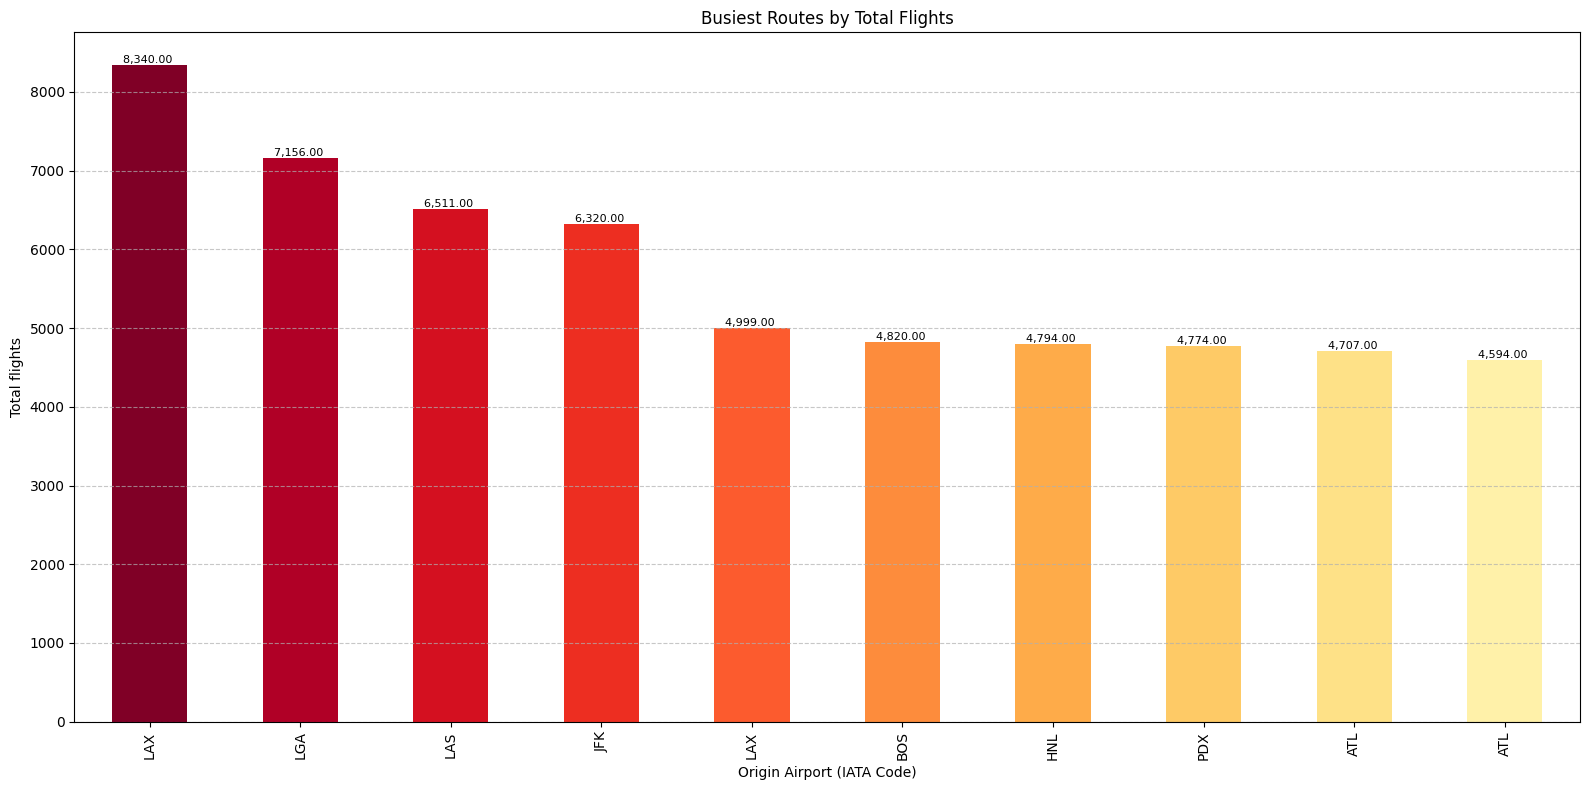

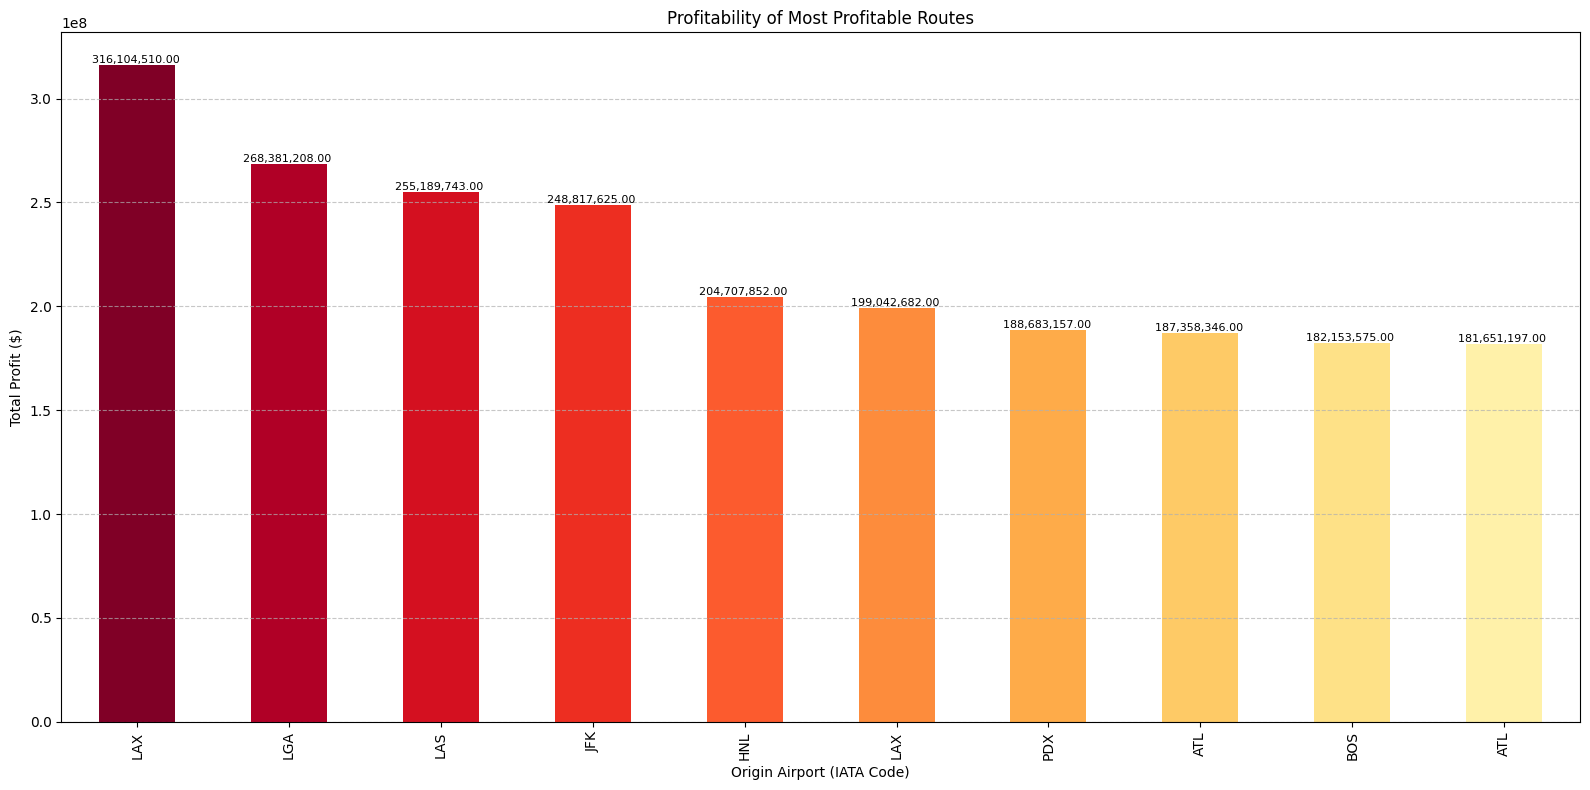

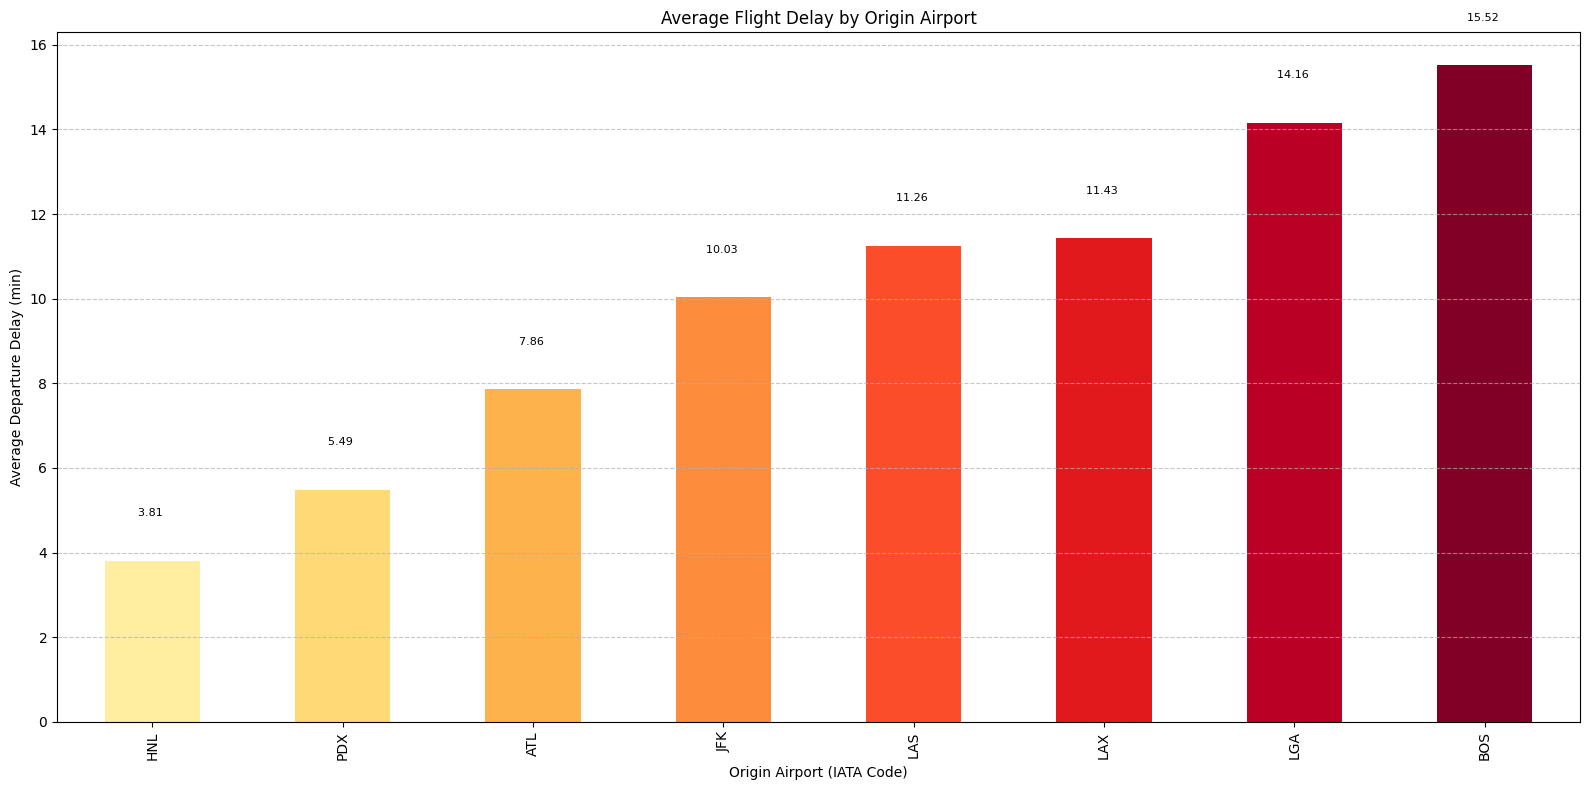

In [17]:
plot_graphs(top_ten_flights,index_name='ORIGIN_IATA_CODE', x_label='Origin Airport (IATA Code)', y_label='Total flights', title='Busiest Routes by Total Flights')
plot_graphs(top_ten_profits,index_name='ORIGIN_IATA_CODE' , df_col='Profit', x_label='Origin Airport (IATA Code)', y_label='Total Profit ($)', title='Profitability of Most Profitable Routes')
plot_graphs(delays,index_name=None, x_label='Origin Airport (IATA Code)', y_label='Average Departure Delay (min)', title='Average Flight Delay by Origin Airport')